Ben Maxey

MATH 3316

# Newton Interpolation

## Procedure

In this section, we were tasked with designing a function to interpolate a set of data points using Newton interpolation.  Newton interpolation generates a polynomial $p_n(x)$ from $n + 1$ nodes using Newton basis functions.  The basis functions are defined as $\phi_{n+1}(x) = (x - x_0)(x - x_1)...(x - x_n)$, and the Newton polynomial is defined as $p_n(x) = a_0 + a_1\phi_1(x) + ... + a_n\phi_n(x)$.  To implement this interpolation method, I wrote three functions that construct the Newton polynomial.

The first function, Newton_basis, evaluates the Newton basis function $\phi_{n+1}(x)$ at a given value.  As inputs, the function takes a Matrix containing the x-values of the given data points (nodes), a degree $n$, and the point at which to evaluate the function, $x$.  The code for this function is given below.

In [ ]:
double Newton_basis(Matrix& xnodes, int n, double x)
{
	double product = 1.0;

	for (int i = 0; i <= n; i++)
		product *= x - xnodes(i);

	return product;
}

The second function, Newton_nestedform, evaluates the Newton polynomial using Horner's method (nested multiplication).  As inputs, Newton_nestedform takes a Matrix containing the weights of each basis function, a Matrix containing the interpolation nodes, and the point at which to evaluate the function.  The code for this function is given below.

In [ ]:
double Newton_nestedform(Matrix& a, Matrix& xnodes, double x)
{
	int n = a.Cols() - 1;
	double output = a(n);

	for (int i = n - 1; i >= 0; i--)
		output = a(i) + output * (x - xnodes(i));

	return output;
}

The final function, Newton_coefficients, returns a Matrix with the coefficients or weights for the Newton polynomial.  Because a polynomial of degree $n + 1$ can be built in the following way: $p_{n+1}(x) = p_n(x) + a_{n+1}\phi_{n+1}(x)$, the coefficients can be determined recursively using previously found coefficients.  The first coefficient $a_0$ simply equals $y_0$, and each of the following coefficients can be determined from the following equation: $a_{n+1} = \frac{y_{n+1} - p_n(x_{n+1})}{\phi_{n+1}(x_{n+1})}$.  The function takes two Matrices with the x-values and y-values of the given data.

In [ ]:
Matrix Newton_coefficients(Matrix& xnodes, Matrix& ynodes)
{
	Matrix a(1,xnodes.Cols());
	a(0) = ynodes(0);

	for (int i = 1; i < xnodes.Cols(); i++)
	{
		double pnx = Newton_nestedform(a, xnodes, xnodes(i));
		double basis = Newton_basis(xnodes, i - 1, xnodes(i));
		a(i) = (ynodes(i) - pnx) / basis;
	}

	return a;
}

To test these functions, I used the functions to interpolate the data $(x_i,y_i), 0 \leq i \leq 4$ generated by the polynomial $f(x) = 3.1x^4 + 2.3x^3 - 6.6x^2 + 8.7x + 7.9$, where the nodes $x_i$ are $-2, -1, 0, 1, 2$.  In generating these nodes, I defined a Fcn subclass for $f(x)$.  The constructed polynomial $p_4(x)$ and the original function $f(x)$ will both be evaluated at 201 equally spaced values between -3 and 3.  The code for this process is given below.

In [ ]:
#include <iostream>
#include <cmath>

#include "fcn.hpp"
#include "newton.hpp"

class testFcn : public Fcn
{
public:
	double operator() (double x)
	{
		return 3.1 * pow(x, 4) + 2.3 * pow(x, 3) - 6.6 * pow(x, 2) +
			8.7 * x + 7.9;
	}
};

int main(int argc, char** argv)
{
	testFcn f;

	double xvalues[5] = {-2, -1, 0, 1, 2};
	Matrix xnodes(1, 5, xvalues);
	Matrix ynodes(1, 5);

	for (int i = 0; i < 5; i++)
		ynodes(i) = f(xnodes(i));

	Matrix a = Newton_coefficients(xnodes, ynodes);

	Matrix x = Linspace(-3, 3, 1, 201);
	Matrix fx(1, 201);
	Matrix pnx(1, 201);
	Matrix err(1, 201);

	for (int i = 0; i < 201; i++)
	{
		fx(i) = f(x(i));
		pnx(i) = Newton_nestedform(a, xnodes, x(i));
		err(i) = fx(i) - pnx(i);
	}

	x.Write("x.txt");
	fx.Write("fx.txt");
	pnx.Write("pnx.txt");
	err.Write("err.txt");
}

## Results

As stated previously, both $p_4(x)$ and $f(x)$ were evaluated at 201 equally spaced values between -3 and 3.  The interpolation error, $err(x) = f(x) - p_4(x)$, was also evaluated at these points.  The graphs of each of these functions are shown below.

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
x = loadtxt("x.txt")
fx = loadtxt("fx.txt")
pnx = loadtxt("pnx.txt")
err = loadtxt("err.txt")

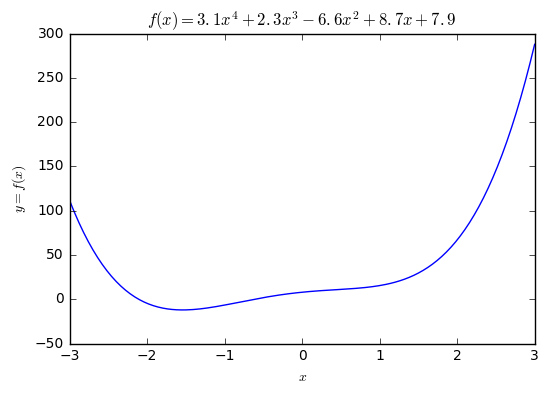

In [9]:
plot(x,fx)
title("$f(x) = 3.1x^4 + 2.3x^3 - 6.6x^2 + 8.7x + 7.9$")
xlabel("$x$")
ylabel("$y = f(x)$")

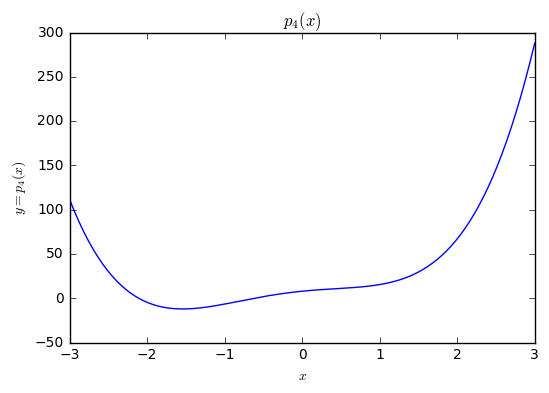

In [11]:
plot(x,pnx)
title("$p_4(x)$")
xlabel("$x$")
ylabel("$y = p_4(x)$")

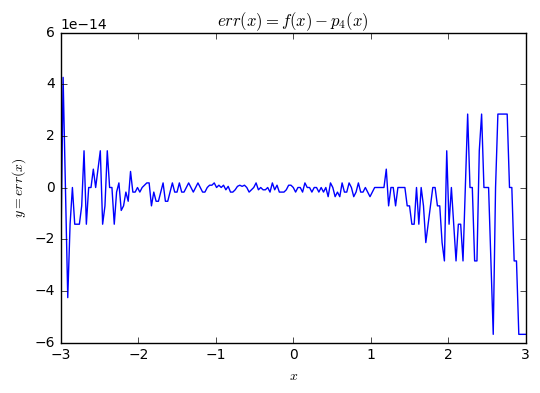

In [12]:
plot(x,err)
title("$err(x) = f(x) - p_4(x)$")
xlabel("$x$")
ylabel("$y = err(x)$")

Because the five nodes used were distinct, the existence and uniqueness theorem guarantees a unique polynomial $p_4(x)$ of degree 4 that interpolates the data.  Since $f(x)$ is also a degree 4 polynomial, we expect $p_4(x)$ and $f(x)$ to be the same.  The plots match this expectation, as the curves themselves appear identical and the error is extremely small.  The error is nonzero most likely due to rounding errors.  The magnitude of the error is small enough to support this possible explanation.  While the absolute error increases when $x < -2$ and when $x > 1$, the relative error should remain relatively stable because the original function greatly increases in value outside of the range $-2 < x < 1$.

# Multi-dimensional Interpolation

## Procedure

In this section, we were tasked with implementing a method to interpolate a two-dimensional function using Lagrange interpolation.  One-dimensional Lagrange interpolation is accomplished with Lagrange basis functions: $\phi_i(x) = \prod_{k=0,k\neq i}^n \frac{x - x_k}{x_i - x_k}, 0 \leq i \leq n$, for $(n + 1)$ data points.  The Lagrange polynomial is given as follows: $p_n(x) = \sum_{i=0}^n f(x_i)\phi_i(x)$.  In the two-dimensional case, the Lagrange basis functions can be written as the product of two bases, one in the x-direction and one in the y-direction: $l_{i,j} = \phi_i(x)\psi_j(y)$, where $0 \leq i \leq m, 0 \leq j \leq n$ for $(m + 1)(n + 1)$ data points.  The Lagrange interpolant can then be calculated at a given point $(a,b)$ as $p(a,b) = \sum_{i=0}^m \sum_{j=0}^n f(x_i,y_j)l_{i,j}(a,b)$.

The function Lagrange2D uses the above definition of $p(a,b)$ to interpolate a given data set.  As inputs, the function takes two Matrices of lengths $(m + 1)$ and $(n + 1)$ containing the x nodes and y nodes, a third $(m + 1) x (n + 1)$ Matrix containing the function values $f(x_i,y_j)$, and two doubles corresponding to an evaluation point.  For this project, we were given a pre-written function, Lagrange, that evaluates a Lagrange polynomial at a specified point given two Matrices with interpolation nodes and data.  Because the two-dimensional Lagrange basis is just a product of two one-dimensional Lagrange bases, the Lagrange2D function calls the Lagrange function to calculate the value of the two-dimensional basis function.  After this step, all that remains is multiplying by the given function's true value and summing.  The code for the Lagrange2D function is given below, and the code for the Lagrange function is given in the appendix.

In [ ]:
#include "Lagrange2D.h"
#include "Lagrange.cpp"
#include <iostream>

double Lagrange2D(Matrix& x, Matrix& y, Matrix& f, double a, double b)
{
	double output = 0.0;

	int m = x.Size() - 1;
	int n = y.Size() - 1;

	for (int i = 0; i <= m; i++)
	{
		for (int j = 0; j <= n; j++)
		{
			double xbasis = Lagrange_basis(x, i, a);
			double ybasis = Lagrange_basis(y, j, b);
			output += xbasis * ybasis * f(i, j);
		}
	}

	return output;
}

A test routine, test_Lagrange2D.cpp, was provided to test the function.  This routine interpolates the function $f(x,y) = sinh(2x)cos(3y)$, first using ten nodes equally spaced between -2 and 2, and then using twenty nodes.  Both the original function and the interpolant are evaluated at (75 x 75) points in the range $-2 < x < 2$ and $-2 < y < 2$.  The test routine outputs files containing the true values of the function, the values of the interpolants, and the points at which the functions are evaluated.  The code for this test routine is given in the appendix.

## Results

The plots of the original function, the two interpolating functions, and the error of each interpolation are shown below.

In [6]:
a = loadtxt('a.txt')
b = loadtxt('b.txt')
f = loadtxt('ftrue.txt')
p10 = loadtxt('p10.txt')
p20 = loadtxt('p20.txt')

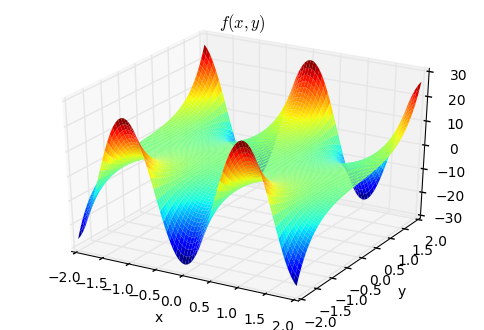

In [7]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = meshgrid(b, a)
surf = ax.plot_surface(X, Y, f, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$f(x,y)$')

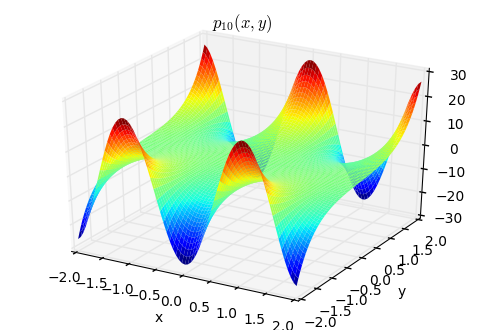

In [8]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, p10, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$p_{10}(x,y)$')

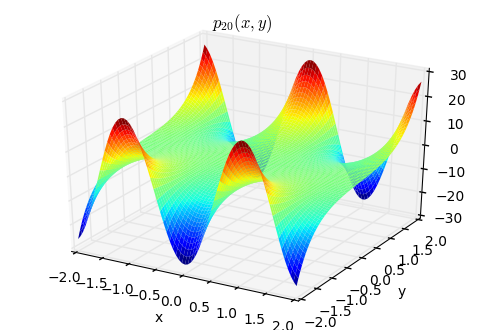

In [9]:
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, p20, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$p_{20}(x,y)$')

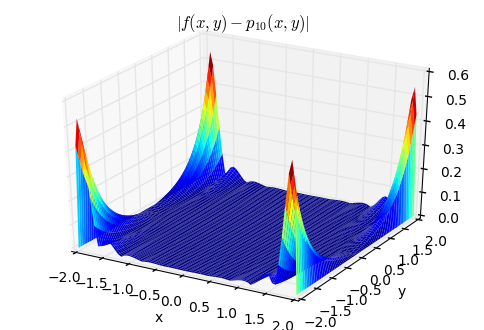

In [10]:
e10 = abs(f-p10)
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, e10, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$|f(x,y) - p_{10}(x,y)|$')

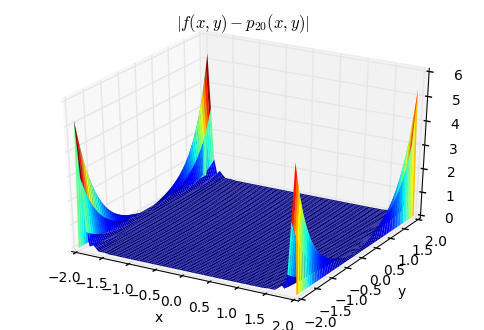

In [11]:
e20 = abs(f-p20)
fig = figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, e20, rstride=1, cstride=1, linewidth=0, cmap=cm.jet)
ax.set_xlabel('x')
ax.set_ylabel('y')
title('$|f(x,y) - p_{20}(x,y)|$')

In [14]:
e10norm = sqrt(sum(sum(e10**2))/size(e10))
e20norm = sqrt(sum(sum(e20**2))/size(e20))
print ('||e10|| = ', e10norm)
print ('||e20|| = ', e20norm)

||e10|| =  0.0575277609593
||e20|| =  3.69239841116e-08


The project description gave error tolerances for each interpolation.  For ten nodes, the error norm was required to be less than 0.058, and for twenty nodes the error norm was required to be less than 3.7e-08.  As demonstrated above, both error norms are below these tolerances.  The error increases dramatically near the boundaries for both interpolations, but this is expected, as the interpolations do not accurately estimate the function outside the range of the given nodes.  The error also decreases significantly when the number of nodes is increased.

# The Importance of Nodes

## Procedure

In this section, we were tasked with interpolating a two-dimensional Runge function, $f(x,y) = \frac{1}{1 + x^2 + y^2}$, using the Lagrange2D function developed in the previous section.  First the Runge function will be interpolated using sets of uniformly spaced nodes, and then it will be interpolated using sets of Chebyshev nodes.  The domain for this section will be the rectangle $-4 \leq x \leq 4, -4 \leq y \leq 4$.  Four different interpolants will be generated: two using uniformly spaced nodes and two using Chebyshev nodes.  Sets of 6 nodes and 24 nodes will be used for both the uniform and Chebyshev nodes.

For each interpolant, the program first generates the set of nodes.  The uniformly-spaced nodes are generated with Linspace, and the $(m + 1)$ Chebyshev nodes are given by $x_i = 4cos(\frac{(2i + 1)\pi}{2m + 2}), i = 0, ..., m$.  The Runge function is evaluated at 201 evenly spaced points in the x-direction and 101 evenly spaced points in the y-direction.  The program creates two Matrices containing the true function values at only the interpolation nodes, and at all evaluation points.  Finally, the program uses the Lagrange2D to evaluate each interpolant at the $(201 x 101)$ evaluation points.  Both the Runge_uniform.cpp and Runge_Chebyshev.cpp programs are shown below.

In [ ]:
# %load Runge_uniform.cpp
#include "matrix.hpp"
#include "Lagrange2D.h"

class Runge
{
public:
	double operator() (double x, double y)
	{
		double denom = 1.0 + x * x + y * y;
		return 1.0/denom;
	}
};

int main(int argc, char** argv)
{
	Runge function;

	Matrix avals = Linspace(-4, 4, 1, 201);
	Matrix bvals = Linspace(-4, 4, 1, 101);

	Matrix x6 = Linspace(-4, 4, 1, 7);
	Matrix y6 = Linspace(-4, 4, 1, 7);
	
	Matrix f6(7,7);
	for (int i = 0; i < 7; i++)
	{
		for (int j = 0; j < 7; j++)
			f6(i,j) = function(x6(i), y6(j));
	}

	Matrix p6(201,101);
	for (int i = 0; i < 201; i++)
	{
		for (int j = 0; j < 101; j++)
			p6(i,j) = Lagrange2D(x6, y6, f6, avals(i), bvals(j));
	}

	Matrix x24 = Linspace(-4, 4, 1, 25);
	Matrix y24 = Linspace(-4, 4, 1, 25);

	Matrix f24(25,25);
	for (int i = 0; i < 25; i++)
	{
		for (int j = 0; j < 25; j++)
			f24(i,j) = function(x24(i), y24(j));
	}

	Matrix p24(201,101);
	for (int i = 0; i < 201; i++)
	{
		for (int j = 0; j < 101; j++)
			p24(i,j) = Lagrange2D(x24, y24, f24, avals(i), bvals(j));
	}

	Matrix runge(201,101);
	for (int i = 0; i < 201; i++)
	{
		for (int j = 0; j < 101; j++)
			runge(i,j) = function(avals(i), bvals(j));
	}

	avals.Write("avals.txt");
	bvals.Write("bvals.txt");
	p6.Write("p6.uni.txt");
	p24.Write("p24.uni.txt");
	runge.Write("runge.txt");
}

In [ ]:
# %load Runge_Chebyshev.cpp
#include <cmath>

#include "matrix.hpp"
#include "Lagrange2D.h"

class Runge
{
public:
	double operator() (double x, double y)
	{
		double denom = 1.0 + x * x + y * y;
		return 1.0/denom;
	}
};

class Chebyshev
{
public:
	double operator() (double L, double m, double i)
	{
		const double PI = 3.14159265;
		double argument = (2 * i + 1) * PI / (2 * m + 2);
		return L * cos(argument);
	}
};

int main(int argc, char** argv)
{
	Runge function;
	Chebyshev node;

	Matrix avals = Linspace(-4, 4, 1, 201);
	Matrix bvals = Linspace(-4, 4, 1, 101);

	Matrix x6(1,7);
	for (int i = 0; i < 7; i++)
		x6(i) = node(4, 6, i);

	Matrix y6(1,7);
	for (int i = 0; i < 7; i++)
		y6(i) = node(4, 6, i);

	Matrix f6(7,7);
	for (int i = 0; i < 7; i++)
	{
		for (int j = 0; j < 7; j++)
			f6(i,j) = function(x6(i), y6(j));
	}

	Matrix p6(201,101);
	for (int i = 0; i < 201; i++)
	{
		for (int j = 0; j < 101; j++)
			p6(i,j) = Lagrange2D(x6, y6, f6, avals(i), bvals(j));
	}

	Matrix x24(1,25);
	for (int i = 0; i < 25; i++)
		x24(i) = node(4, 24, i);

	Matrix y24(1,25);
	for (int i = 0; i < 25; i++)
		y24(i) = node(4, 24, i);

	Matrix f24(25,25);
	for (int i = 0; i < 25; i++)
	{
		for (int j = 0; j < 25; j++)
			f24(i,j) = function(x24(i), y24(j));
	}

	Matrix p24(201,101);
	for (int i = 0; i < 201; i++)
	{
		for (int j = 0; j < 101; j++)
			p24(i,j) = Lagrange2D(x24, y24, f24, avals(i), bvals(j));
	}

	p6.Write("p6.Cheb.txt");
	p24.Write("p24.Cheb.txt");
}

## Results

The plots for the Runge function itself, the four interpolants, and the errors in each interpolation are given in Runge.ipynb.  However, the error norms are calculated below.

In [18]:
runge = loadtxt("runge.txt")
p6_uni = loadtxt("p6.uni.txt")
p24_uni = loadtxt("p24.uni.txt")
p6_Cheb = loadtxt("p6.Cheb.txt")
p24_Cheb = loadtxt("p24.Cheb.txt")

err6u = abs(runge - p6_uni)
err24u = abs(runge - p24_uni)
err6c = abs(runge - p6_Cheb)
err24c = abs(runge - p24_Cheb)

err6unorm = sqrt(sum(sum(err6u**2))/size(err6u))
err24unorm = sqrt(sum(sum(err24u**2))/size(err24u))
err6cnorm = sqrt(sum(sum(err6c**2))/size(err6u))
err24cnorm = sqrt(sum(sum(err24c**2))/size(err6u))

print ('||err6u|| = ', err6unorm)
print ('||err24u|| = ', err24unorm)
print ('||err6c|| = ', err6cnorm)
print ('||err24c|| = ', err24cnorm)

||err6u|| =  0.141951275763
||err24u|| =  3340.29450949
||err6c|| =  0.0662029700782
||err24c|| =  0.00043871378334


Whereas increasing $n$ in interpolations with uniformly-spaced nodes increased the error norm, increasing $n$ in interpolations using Chebyshev nodes resulted in a significant lessening of error.  In terms of quality, the four approaches are ranked as follows:

1. 24 Chebyshev nodes
2. 6 Chebyshev nodes
3. 6 uniform nodes
4. 24 uniform nodes

The one-dimensional interpolation error bound is given by $f(x) - p(x) = \frac{f^{(n+1)}(c)}{(n + 1)!}\prod_{i=0}^n(x - x_i)$.  Because the denominator of the expression contains $(n + 1)!$, one would expect that increasing the number of nodes drastically decreases the maximum error.  However, when nodes are chosen ineffectively, the error can still be large, as was demonstrated by the results of this section.  The product term multiplies the differences in a given x value with all of the x node values.  This term is responsible for the dramatic increase in error when using uniform nodes over Chebyshev nodes.

# Appendix

## Makefile

In [ ]:
# %load Makefile
FLAG = -std=c++14

all: test_Newtonform lagrange2D runge_uniform runge_chebyshev

test_Newtonform: test_Newtonform.o newton.o matrix.o
	g++ $^ $(FLAG) -o $@

lagrange2D: test_Lagrange2D.o matrix.o
	g++ $^ $(FLAG) -o $@

runge_uniform: Runge_uniform.o Lagrange2D.o matrix.o
	g++ $^ $(FLAG) -o $@

runge_chebyshev: Runge_Chebyshev.o Lagrange2D.o matrix.o
	g++ $^ $(FLAG) -o $@

%.o: %.cpp
	g++ -c $< $(FLAG)

clean:
	rm -f *.txt *.o test_Newtonform lagrange2D runge_uniform runge_chebyshev

## Lagrange.cpp

In [ ]:
# %load Lagrange.cpp
/* Daniel R. Reynolds
   SMU Mathematics
   Math 3316
   30 September 2015 */

// Inclusions
#include <stdlib.h>
#include <stdio.h>
#include <iostream>
#include <math.h>
#include "matrix.hpp"

using namespace std;


// Utility function to evaluate a given Lagrange basis function at a point, phi_i(z).
//
// Usage: l = Lagrange_basis(x, i, z);
//
// inputs:   x     Matrix of length n+1, containing the interpolation nodes
//           i     integer indicating which Lagrange basis function to evaluate
//           z     double location to evaluate basis function
// outputs:  p     value of phi_i(z)
// 
double Lagrange_basis(Matrix& x, int i, double z) {
  double l = 1.0;              // initialize basis function
  for (size_t j=0; j<x.Size(); j++)
     if (j != i)
       l *= (z - x(j)) / (x(i) - x(j));
  return l;
}



// This routine evaluates the Lagrange interpolating polynomial, 
// defined over a set of data points (x_i,y_i), i=0,...,n, at a point z.
//
// Usage: p = Lagrange(x, y, z);
//
// inputs:   x     Matrix of length n+1, containing the interpolation nodes
//           y     Matrix of length n+1, containing the interpolation data
//           z     double location to evaluate polynomial
// outputs:  p     value of p(z)
// 
double Lagrange(Matrix& x, Matrix& y, double z) {

  // check input arguments (lengths of x and y)
  if (x.Size() != y.Size()) {
    cerr << "Lagrange error: x and y have different lengths!\n";
    return 0.0;
  }

  // evaluate p
  double p = 0.0;                       // initialize result
  for (size_t i=0; i<x.Size(); i++)     // loop over data values
    p += y(i)*Lagrange_basis(x, i, z);  // update result with next term

  // return final result
  return p;

} // end of function


## test_Lagrange2D.cpp

In [ ]:
# %load test_Lagrange2D.cpp
/* Daniel R. Reynolds
   SMU Mathematics
   Math 3316
   1 October 2015 */

// Inclusions
#include <stdlib.h>
#include <stdio.h>
#include <iostream>
#include <math.h>
#include "matrix.hpp"
#include "Lagrange2D.cpp"
using namespace std;

// function prototypes
//double Lagrange2D(Matrix& x, Matrix& y, Matrix& z, double a, double b);


// This routine tests the function lagrange2D.cpp.
int main(int argc, char* argv[]) {

  // create Lambda function for f(x,y)
  auto f = [](const double x, const double y) -> double { 
    return (sinh(2.0*x)*cos(3.0*y));
  };


  ///////////////
  // first, test with 11 nodes in each direction
  int m = 10;                               // set m
  int n = 10;                               // set n
  Matrix x = Linspace(-2.0, 2.0, m+1, 1);   // set nodes
  Matrix y = Linspace(-2.0, 2.0, n+1, 1);
  Matrix z(m+1,n+1);                        // initialize data
  for (int j=0; j<=n; j++)  
    for (int i=0; i<=m; i++)
      z(i,j) = f(x(i), y(j));               // fill data

  // set evaluation points (a,b) in a mesh over the domain
  Matrix a = Linspace(-2.0, 2.0, 75, 1);
  Matrix b = Linspace(-2.0, 2.0, 75, 1);

  // output evaluation points to disk
  a.Write("a.txt");
  b.Write("b.txt");

  // evaluate the polynomial at the points (a,b), storing in p
  Matrix p(75,75);
  for (int j=0; j<75; j++) 
    for (int i=0; i<75; i++) 
      p(i,j) = Lagrange2D(x, y, z, a(i), b(j));

  // output p to disk
  p.Write("p10.txt");

  // evaluate the true function at the points (a,b), storing in ftrue
  Matrix ftrue(75,75);
  for (int j=0; j<75; j++) 
    for (int i=0; i<75; i++) 
      ftrue(i,j) = f(a(i), b(j));

  // output true function to disk
  ftrue.Write("ftrue.txt");


  ///////////////
  // repeate test with 21 nodes in each direction
  m = 20;                                    // set m
  n = 20;                                    // set n
  Matrix x2 = Linspace(-2.0, 2.0, m+1, 1);   // set nodes
  Matrix y2 = Linspace(-2.0, 2.0, n+1, 1);
  Matrix z2(m+1,n+1);                        // initialize data
  for (int j=0; j<=n; j++)  
    for (int i=0; i<=m; i++)
      z2(i,j) = f(x2(i), y2(j));             // fill data

  // evaluate the polynomial at the points (a,b), storing back in p
  for (int j=0; j<75; j++) 
    for (int i=0; i<75; i++) 
      p(i,j) = Lagrange2D(x2, y2, z2, a(i), b(j));

  // output p to disk
  p.Write("p20.txt");

} // end routine